In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import json
import os
import contextily as ctx
import numpy as np
import dask.dataframe as dd
# import tensorflow as tf

from adjustText import adjust_text
from shapely.geometry import Polygon

In [2]:
from tensorflow.signal import rfft

# Getting Data

## Hydrological Data

The list of stations used by the Federal Office of the environment can be found on this page: https://www.bafu.admin.ch/bafu/de/home/themen/wasser/daten-karten/wasser--messnetze/basismessnetz--wasserstand-und-abfluss-an-oberflaechengewaessern.html#46775952

In [3]:
station_list = pd.read_excel("data/hydrology/Stationsliste_HydrowebSAM_DE_Juli2023.xlsx", skiprows=4)

# Restrict list to stations which are active, are part of the aare system and where discharge is measured
aare_stations = station_list[
    (station_list["Betriebsstatus"] == "in Betrieb") & 
    (station_list["Flussgebiet"] == "Aaregebiet") & 
    (station_list["Messparameter"]  == "Abfluss")
]

# convert to geopandas for ease of plot
aare_stations = gpd.GeoDataFrame(
    aare_stations,
    geometry=gpd.points_from_xy(x=aare_stations["X-Koordinate"], y=aare_stations["Y-Koordinate"]),
    crs='EPSG:2056'
)

aare_stations.head()

,Betriebsstatus,Flussgebiet,Stationsnr.,Gewässer,Stationsname,Gewässertyp,X-Koordinate,Y-Koordinate,Stationshöhe [m ü.M.],Einzugsgebietsfläche [km2],Mittlere Einzugsgebietshöhe [m ü.M.],Vergletscherungsanteil [%],Messparameter,Daten verfügbar ab,Daten verfügbar bis,geometry
2,in Betrieb,Aaregebiet,70,Emme,Emmenmatt,Fliessgewässer,2623616,1200426.0,641,443.0,1065.0,0.0,Abfluss,1909-01-01,heute,POINT (2623616 1200426)
4,in Betrieb,Aaregebiet,155,Emme,"Wiler, Limpachmündung",Fliessgewässer,2608228,1223238.0,459,937.0,858.0,0.0,Abfluss,1921-07-01,heute,POINT (2608228 1223238)
27,in Betrieb,Aaregebiet,488,Simme,Latterbach,Fliessgewässer,2610681,1167849.0,666,563.0,1594.0,1.5,Abfluss,1985-05-01,heute,POINT (2610681 1167849)
60,in Betrieb,Aaregebiet,2016,Aare,Brugg,Fliessgewässer,2656959,1259353.0,336,11681.0,1000.0,1.5,Abfluss,1916-01-01,heute,POINT (2656959 1259353)
70,in Betrieb,Aaregebiet,2019,Aare,Brienzwiler,Fliessgewässer,2649942,1177374.0,574,555.0,2135.0,15.5,Abfluss,1905-01-01,heute,POINT (2649942 1177374)


Choice (up for debate): Aare-Hagneck as target which has `Stationsnr. = 2085`

In [4]:
def get_catchment_geometry(station_no: str) -> gpd.GeoDataFrame | int:
    try:
        with urllib.request.urlopen(f"https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bafu.hydrologie-hydromessstationen/{station_no}") as url:
            data = json.load(url)
            geometry = data.get('feature').get('geometry')
        # somewhat strong assumption: it seems, the geometry for all stations is defined as a ring - convert to shapely.Polygon
        catchment_geom = Polygon(geometry['rings'][0])
        catchment_geom = gpd.GeoDataFrame([{'geometry': catchment_geom}], crs="EPSG:21781") #EPSG:21781 the LV95 coordinate projection
        return catchment_geom
    except Exception as e:
        print(f"Something went wrong: {e}")
        return 0

catchment = get_catchment_geometry("2085")

In [5]:
# change the coordinate projection to the OpenStreetMap projection
catchment = catchment.to_crs(epsg=3857)
aare_stations = aare_stations.to_crs(epsg=3857)

# create a column whether a station is in catchment = is upriver 
aare_stations["in_catchment"] = aare_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

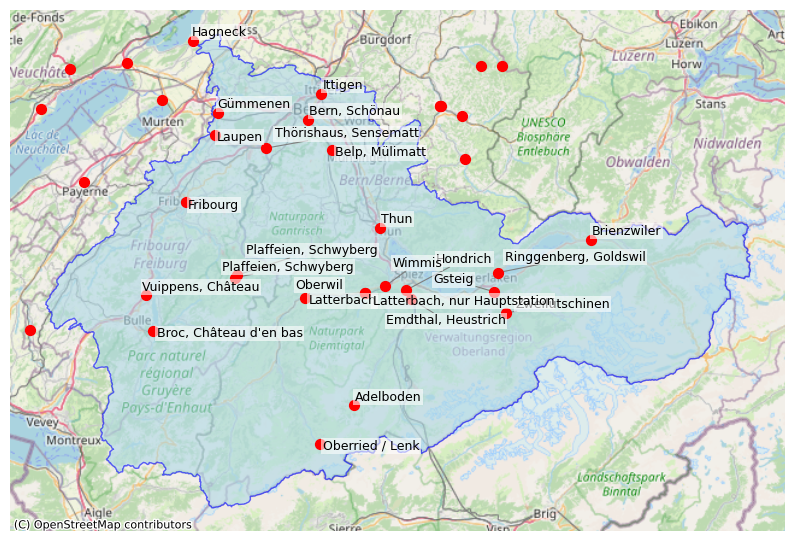

In [6]:
# Plot with map
fig, ax = plt.subplots(figsize=(10, 8))
catchment.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.6)

# Add basemap (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add hydrological stations and name those in catchment
aare_stations.plot(ax=ax, color="red", markersize=50, zorder=5)

texts = []
for idx, row in aare_stations[aare_stations["in_catchment"]==True].iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            row["Stationsname"],
            fontsize=9,
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
            zorder=6
        )
    )

# Adjust positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))


ax.set_axis_off()
plt.show()

In [6]:
# Load data
hydro = pd.read_csv("data/hydrology/aare_2010.csv")
for year in np.arange(2011, 2025):
    tmp = pd.read_csv(f"data/hydrology/aare_{year}.csv")
    hydro = pd.concat([hydro, tmp])

# convert index to datetime
date_time = pd.to_datetime(hydro['timestamp'], format='%Y-%m-%d %H:%M:%S.000000 UTC')
hydro = hydro.set_index(date_time)

# convert to wide data frame
wide_hydro = hydro.pivot(index="timestamp", columns="station_no", values="value")

# convert column names to str
wide_hydro.columns = wide_hydro.columns.astype(str)

wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


In [7]:
wide_hydro = wide_hydro.interpolate(method="linear")
wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


### Seasonal cycle?

Does our target Hagneck show a clear seasonal cycle? To answer, let's perform a quick fourier transformation

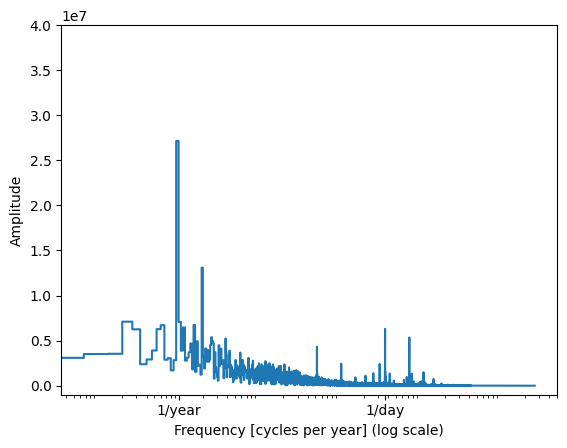

In [8]:

# Your series for station 2085
x = wide_hydro["2085"].values
n_samples = len(x)

# --- FFT ---
fft = rfft(x)

# --- Frequency axis ---
# Assume your data is hourly → sampling interval = 1 hour
dt = 1.0/6.0   # hours
freqs_per_hour = np.fft.rfftfreq(n_samples, d=dt)

# Convert to cycles per year (instead of per hour)
hours_per_year = 24 * 365.2524
freqs_per_year = freqs_per_hour * hours_per_year

# --- Plot ---
plt.step(freqs_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(-0.01e8, 0.4e8)
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
plt.xlabel("Frequency [cycles per year] (log scale)")
plt.ylabel("Amplitude")
plt.show()


Most pronounced cycle: ~1.00 years


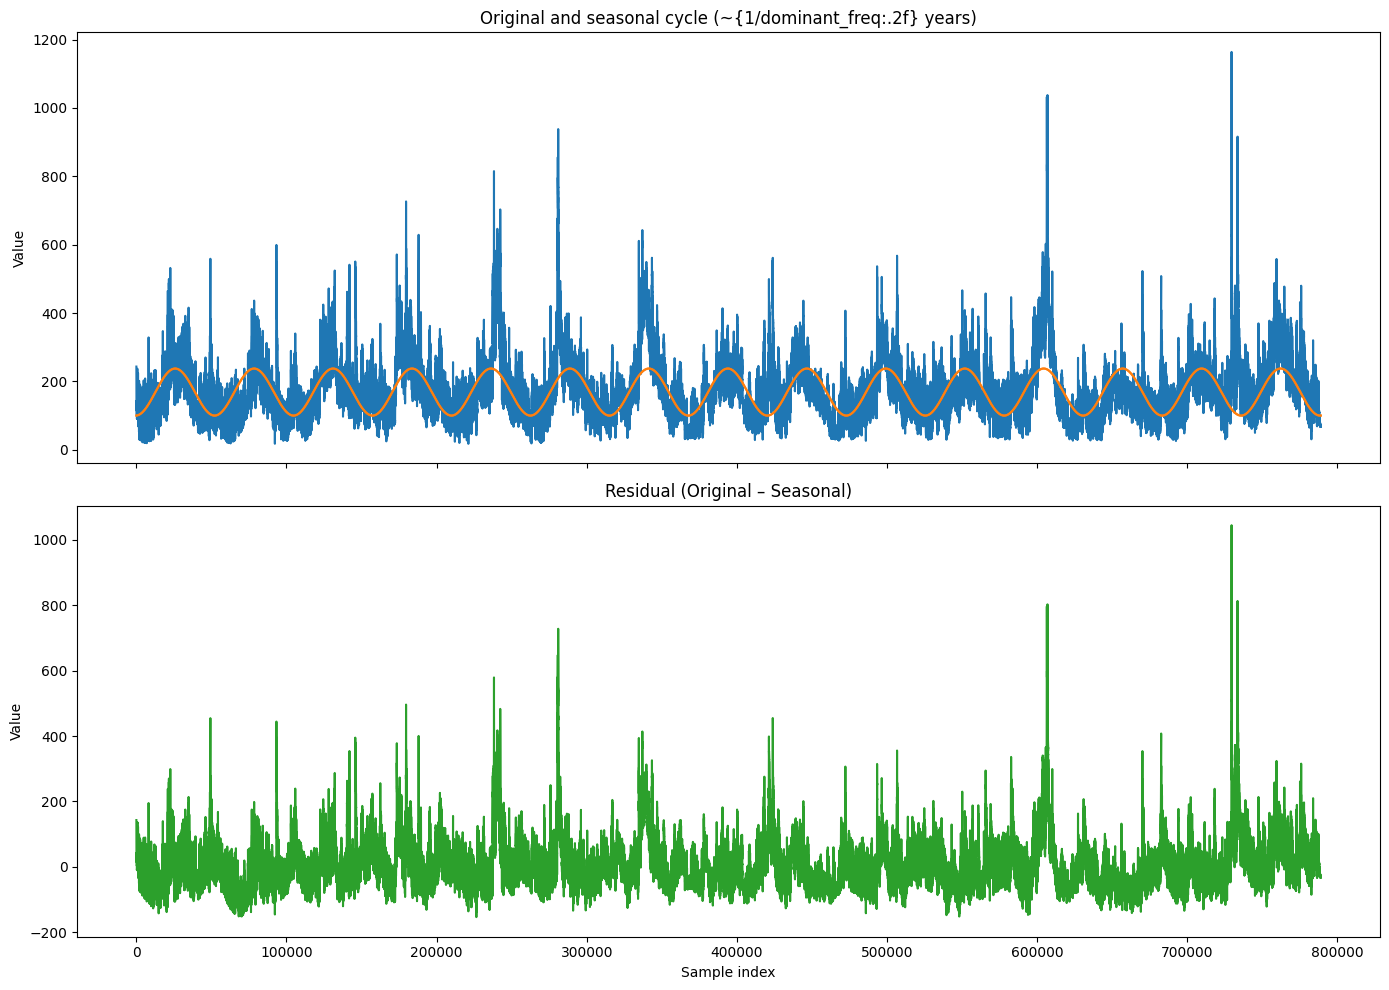

In [10]:
# --- Find dominant frequency ---
power = np.abs(fft)**2
dominant_idx = np.argmax(power[1:]) + 1
dominant_freq = freqs_per_year[dominant_idx]
print(f"Most pronounced cycle: ~{1/dominant_freq:.2f} years")

# --- Reconstruct seasonal component ---
fft_yearly = np.zeros_like(fft, dtype=complex)
fft_yearly[0] = fft[0]                         # keep mean
fft_yearly[dominant_idx] = fft[dominant_idx]   # keep strongest seasonal
seasonal = np.fft.irfft(fft_yearly, n=n_samples)

# --- Residual ---
residual = x - seasonal

# --- Subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(x, color="C0")
axes[0].set_title("Original and seasonal cycle (~{1/dominant_freq:.2f} years)")
axes[0].plot(seasonal, color="C1")
axes[0].plot(seasonal, color="C1")

axes[1].plot(residual, color="C2")
axes[1].set_title("Residual (Original – Seasonal)")

for ax in axes:
    ax.set_ylabel("Value")
axes[-1].set_xlabel("Sample index")

plt.tight_layout()
plt.show()


In [9]:
# ensure DatetimeIndex
wide_hydro.index = pd.to_datetime(wide_hydro.index)
idx = wide_hydro.index  # DatetimeIndex

# day-of-year (1..366), seconds within the day, and days-in-year per timestamp
day_of_year = idx.dayofyear
seconds_of_day = idx.hour * 3600 + idx.minute * 60 + idx.second + idx.microsecond / 1e6
days_in_year = np.where(idx.is_leap_year, 366, 365)

# fractional position in that specific calendar year (0..1)
frac_of_year = ((day_of_year - 1) + seconds_of_day / 86400.0) / days_in_year

wide_hydro['year_sin'] = np.sin(2 * np.pi * frac_of_year)
wide_hydro['year_cos'] = np.cos(2 * np.pi * frac_of_year)


In [10]:
train_hydro = wide_hydro.loc['2010-01-01':'2023-12-31']
test_hydro = wide_hydro.loc['2024-01-01':]

y_train = train_hydro.pop("2085")
y_test = test_hydro.pop("2085")

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

steps = [
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
]
pipeline = Pipeline(steps)

# Fit pipeline directly
pipeline.fit(train_hydro, y_train)

# Predict & evaluate
y_pred = pipeline.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 38.267581982689364
R2: 0.7938562771901408


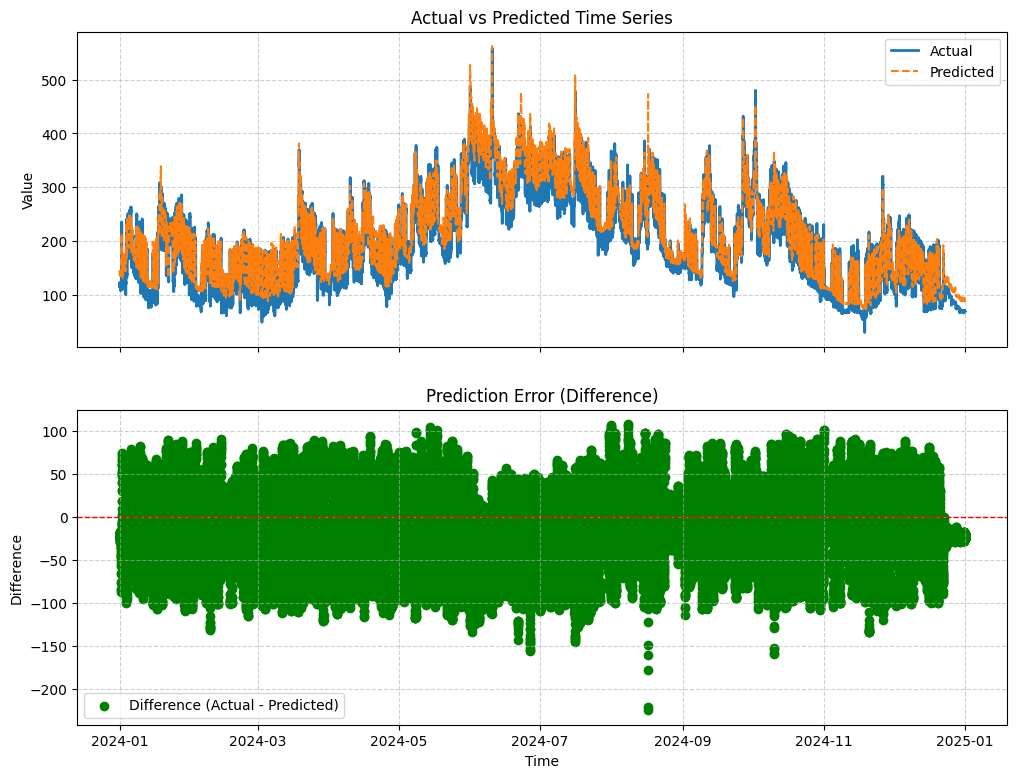

In [14]:
# Make sure y_pred is a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

def plot_time_series(y_pred: pd.Series, y_test: pd.Series):
    fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

    axs[0].plot(y_test.index, y_test, label="Actual", linewidth=2)
    axs[0].plot(y_test.index, y_pred, label="Predicted", linestyle="--")
    axs[0].set_ylabel("Value")
    axs[0].set_title("Actual vs Predicted Time Series")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    difference = y_test.values - y_pred.values
    axs[1].scatter(y_test.index, difference, label="Difference (Actual - Predicted)", color='green')
    # Add a horizontal line at y=0 for reference
    axs[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Difference")
    axs[1].set_title("Prediction Error (Difference)")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_time_series(y_pred_series, y_test)

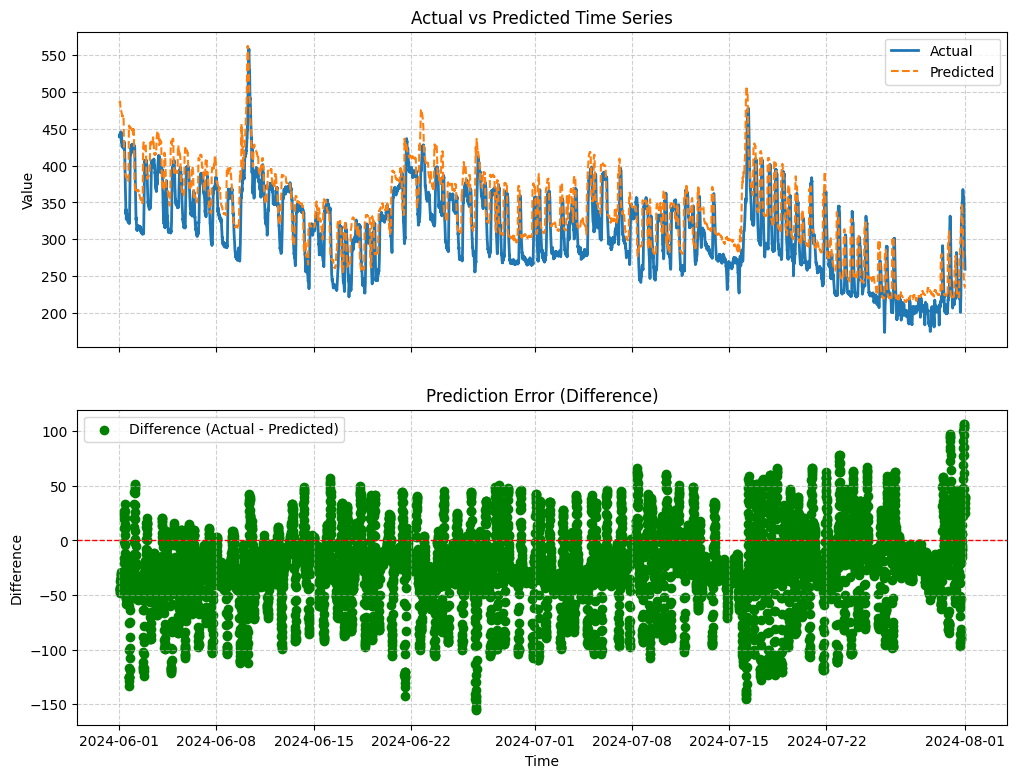

In [15]:
start = "2024-06-01"
end = "2024-08-01"

plot_time_series(y_pred_series[(y_pred_series.index > start) & (y_pred_series.index < end)], y_test[(y_test.index > start) & (y_test.index < end)])
# y_test[(y_test.index > start) & (y_test.index < end)]

### Simple linear regression - with time awareness

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class DaskLagFeaturesAdder(BaseEstimator, TransformerMixin):
    # Add an 'exclude_columns' parameter
    def __init__(self, n_lags=1, exclude_columns=None):
        self.n_lags = n_lags
        self.exclude_columns = exclude_columns if exclude_columns is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.n_lags == 0:
            return X
            
        X_with_lags = X

        for i in range(1, self.n_lags + 1):
            # Only loop through columns that are NOT in the exclude list
            for col in [c for c in X.columns if c not in self.exclude_columns]:
                new_col_name = f'{col}_lag_{i}'
                X_with_lags = X_with_lags.assign(
                    **{new_col_name: X[col].shift(periods=i)}
                )

        return X_with_lags.bfill()
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            raise ValueError("Input feature names are required.")
        
        feature_names = list(input_features)
        if self.n_lags > 0:
            # Create lagged names only for the included columns
            columns_to_lag = [c for c in input_features if c not in self.exclude_columns]
            for i in range(1, self.n_lags + 1):
                for col in columns_to_lag:
                    feature_names.append(f'{col}_lag_{i}')
        return np.array(feature_names, dtype=object)

In [12]:
# Due to performance issue
# Define the target station, lag, and seasonal features
target_station = '2085'
seasonal_features = ['year_sin', 'year_cos']
upstream_stations = [col for col in train_hydro.columns if col not in [target_station] + seasonal_features]

# Load the data again using dask now instead of pandas
file_path = [f"data/hydrology/aare_{year}.csv" for year in np.arange(2010,2024)]
long_format_dd = dd.read_csv(file_path)
long_format_dd['station_no'] = long_format_dd['station_no'].astype('category').cat.as_known()

wide_hydro_dd = long_format_dd.pivot_table(index="timestamp", columns="station_no", values='value')

train_hydro_dd = wide_hydro_dd.map_partitions(lambda df: df.interpolate(method="linear"))
train_hydro_dd.index = dd.to_datetime(train_hydro_dd.index)
train_hydro_dd.columns = [f'{col}' for col in train_hydro_dd.columns]

# add the seasonal cycle lazily
day_of_year = train_hydro_dd.index.dayofyear
days_in_year = 365.25

train_hydro_dd = train_hydro_dd.assign(
    year_sin = np.sin(2 * np.pi * day_of_year / days_in_year),
    year_cos = np.cos(2 * np.pi * day_of_year / days_in_year)
)

y_train = train_hydro_dd[target_station].compute()

# The features (X) remain a lazy Dask DataFrame.
X_train = train_hydro_dd.drop(columns=target_station)

c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.747e+07, tolerance: 4.734e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.394e+07, tolerance: 4.654e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [ ]:
from dask_ml.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# Add a StandardScaler to the numerical pipeline
numerical_pipeline = Pipeline([
    ('lag_adder', DaskLagFeaturesAdder()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numerical_pipeline, upstream_stations)
    ],
    remainder='passthrough'
)

# Create the final pipeline
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=2000))
])

# Define the parameter grid to search
# 'preprocessor__lag_adder__n_lags' refers to the 'n_lags' parameter
# of the 'lag_adder' step, which is inside the 'preprocessor' step.
param_grid = {
    'preprocessor__numerical_features__lag_adder__n_lags': [0, 6, 12, 24, 30, 36],
    'regressor__alpha': [0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

# Create and fit the GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search = GridSearchCV(
    regression_pipeline, 
    param_grid, 
    cv=3,  # Using 3-fold CV as an example
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

print("\nStarting Grid Search... Dask will now execute the plan.")
# This is the only step where the full computation happens. Dask's scheduler
# will process the data in chunks to avoid memory errors.
grid_search.fit(X_train, y_train)

# Print the results
print("\n--- Grid Search Complete ---")
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("\nBest Cross-Validation Score (Negative Mean Squared Error):")
print(grid_search.best_score_)

It seems, that the best fit is at the edge of our grid. To make sure, we extend it, but we keep the best found parameter for $\alpha$ and $L1$.

In [16]:
new_param_grid = {
    # Test new, higher values for n_lags
    'preprocessor__numerical_features__lag_adder__n_lags': [30, 36, 42],
    
    # LOCK the other parameters to their previously found best values
    'regressor__alpha': [0.1],
    'regressor__l1_ratio': [0.9]
}

# Create and fit a NEW GridSearchCV object
new_grid_search = GridSearchCV(
    regression_pipeline, # Your original, unchanged pipeline
    new_param_grid, 
    cv=3,
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

# Fit the new, faster search (assuming X_train, y_train are your training data)
print("Starting new focused grid search...")
new_grid_search.fit(X_train, y_train)
print("New search complete!")

# Print the results of the second run
print(f"Best parameters from second run: {new_grid_search.best_params_}")
print(f"Best score from second run (Neg MSE): {new_grid_search.best_score_}")

Starting new focused grid search...
New search complete!
Best parameters from second run: {'preprocessor__numerical_features__lag_adder__n_lags': 36, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}
Best score from second run (Neg MSE): -174.53973559774553


In [34]:
best_model = new_grid_search.best_estimator_

y_pred = best_model.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 14.207493245855488
R2: 0.971585305652014


In [ ]:
def plot_time_series(y_pred: pd.Series, y_test: pd.Series):
    fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

    axs[0].plot(y_test.index, y_test, label="Actual", linewidth=2)
    axs[0].plot(y_test.index, y_pred, label="Predicted", linestyle="--")
    axs[0].set_ylabel("Value")
    axs[0].set_title("Actual vs Predicted Time Series")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    difference = y_test.values - y_pred.values
    axs[1].scatter(y_test.index, difference, label="Difference (Actual - Predicted)", color='green')
    # Add a horizontal line at y=0 for reference
    axs[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Difference")
    axs[1].set_title("Prediction Error (Difference)")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_time_series(y_pred_series, y_test)

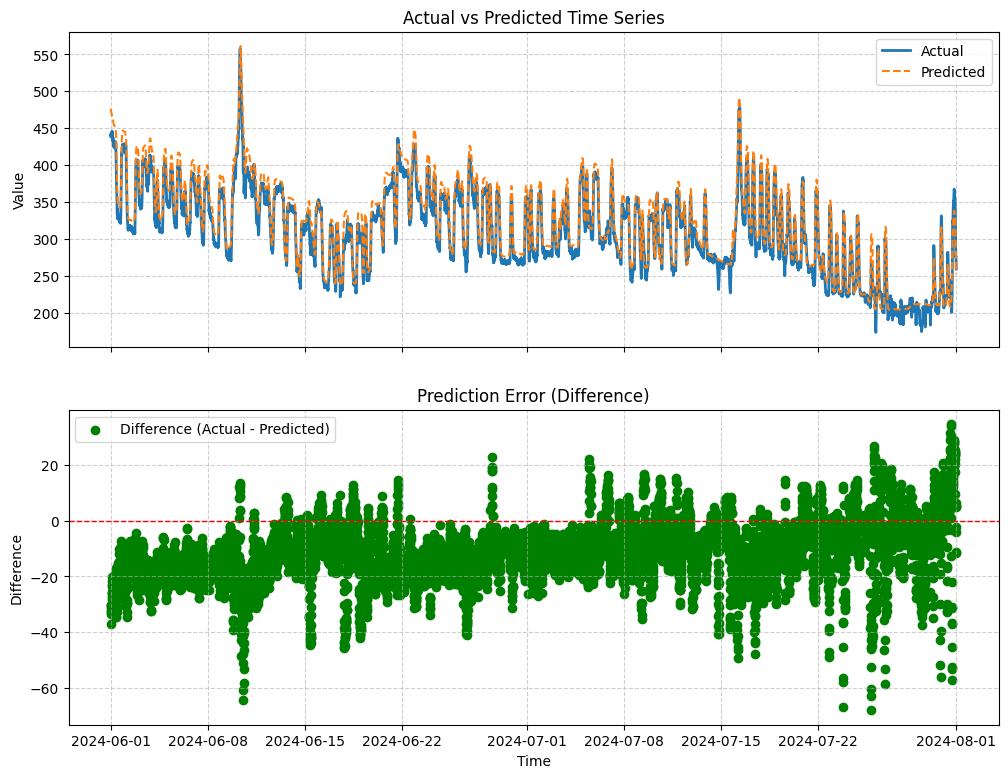

In [31]:
start = "2024-06-01"
end = "2024-08-01"

plot_time_series(y_pred_series[(y_pred_series.index > start) & (y_pred_series.index < end)], y_test[(y_test.index > start) & (y_test.index < end)])

### PCA as feature engineering

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dask_ml.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# This pipeline will create lags, scale, and then apply PCA.
# We pass the seasonal_features to the 'exclude_columns' parameter
station_pipeline = Pipeline([
    ('lag_adder', DaskLagFeaturesAdder(n_lags=2, exclude_columns=seasonal_features)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

time_feature_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Correct the third item in the second tuple
preprocessor = ColumnTransformer(
    transformers=[
        ('station_processing', station_pipeline, upstream_stations),
        ('time_feature_processing', time_feature_pipeline, seasonal_features)
    ],
    remainder='drop'
)

# This preprocessor now correctly handles both sets of features.
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=2000))
])

param_grid = {
    'preprocessor__station_processing__lag_adder__n_lags': [30, 36],
    'regressor__alpha': [0.01, 0.1, 1.0],
    'regressor__l1_ratio': [0.5, 0.9, 0.99]
}

# Create and fit the GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search_pca = GridSearchCV(
    regression_pipeline, 
    param_grid, 
    cv=3,  # Using 3-fold CV as an example
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

grid_search_pca.fit(X_train, y_train)


,estimator,Pipeline(step..._iter=2000))])
,param_grid,"{'preprocessor__station_...sing__lag_adder__n_lags': [30, 36], 'regressor__alpha': [0.01, 0.1, ...], 'regressor__l1_ratio': [0.5, 0.9, ...]}"
,scoring,'neg_mean_squared_error'
,iid,True
,refit,True
,cv,3
,error_score,'raise'
,return_train_score,False
,scheduler,None
,n_jobs,-1
,cache_cv,True


In [15]:
from sklearn.metrics import r2_score
model_pca = grid_search_pca.best_estimator_

y_pred = model_pca.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 17.190394085234477
R2: 0.9584013019804205


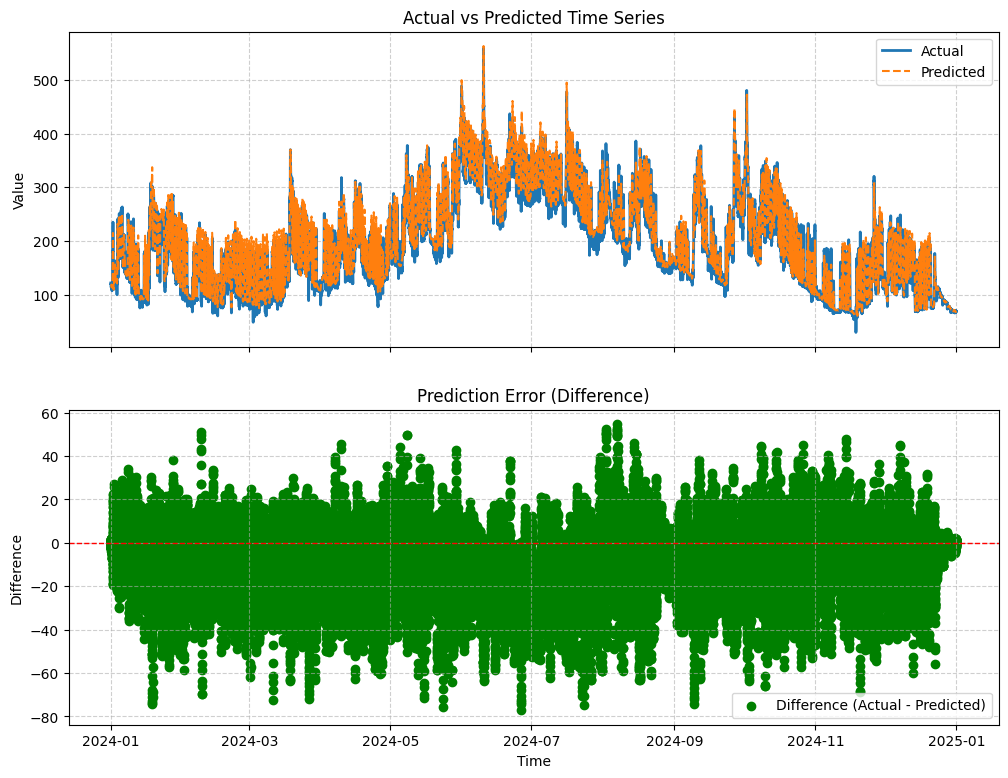

In [21]:
y_pred_series = pd.Series(y_pred, index=y_test.index)
plot_time_series(y_pred_series, y_test)